# 2023-03-13 Spline interpolation

## Last time

* Runge phenomenon as ill conditioning
* Stability and Chebyshev polynomials
* Piecewise methods

## Today

* Accuracy of piecewise constant (nearest neighbor) interpolation
* Piecewise polynomial methods
* Splines
* Libraries

In [1]:
using LinearAlgebra
using Plots
default(linewidth=4, legendfontsize=12)

function vander(x, k=nothing)
    if isnothing(k)
        k = length(x)
    end
    m = length(x)
    V = ones(m, k)
    for j in 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

runge(x) = 1 / (1 + 10*x^2)

CosRange(a, b, n) = (a + b)/2 .+ (b - a)/2 * cos.(LinRange(-pi, 0, n))

vcond(mat, points, nmax) = [cond(mat(points(-1, 1, n))) for n in 2:nmax]

vcond (generic function with 1 method)

# Chebyshev polynomials
$$\begin{split}
T_0(x) &= 1 \\
T_1(x) &= x \\
T_{n+1}(x) &= 2 x T_n(x) - T_{n-1}(x)
\end{split}$$

In [2]:
function vander_chebyshev(x, n=nothing)
    if isnothing(n)
        n = length(x) # Square by default
    end
    m = length(x)
    T = ones(m, n)
    if n > 1
        T[:, 2] = x
    end
    for k in 3:n
        #T[:, k] = x .* T[:, k-1]
        T[:, k] = 2 * x .* T[:,k-1] - T[:, k-2]
    end
    T
end

vander_chebyshev (generic function with 2 methods)

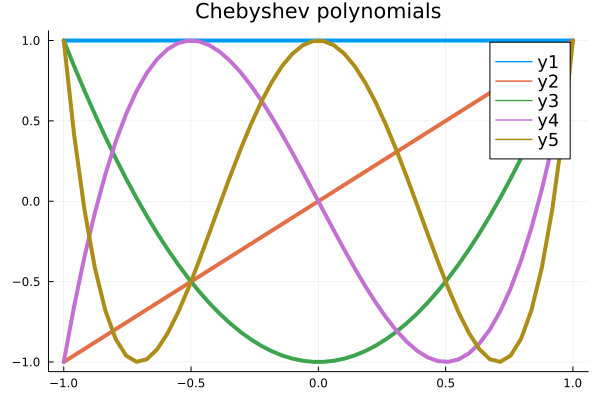

In [3]:
x = LinRange(-1, 1, 50)
plot(x, vander_chebyshev(x, 5), title="Chebyshev polynomials")

# Chebyshev polynomials are well-conditioned



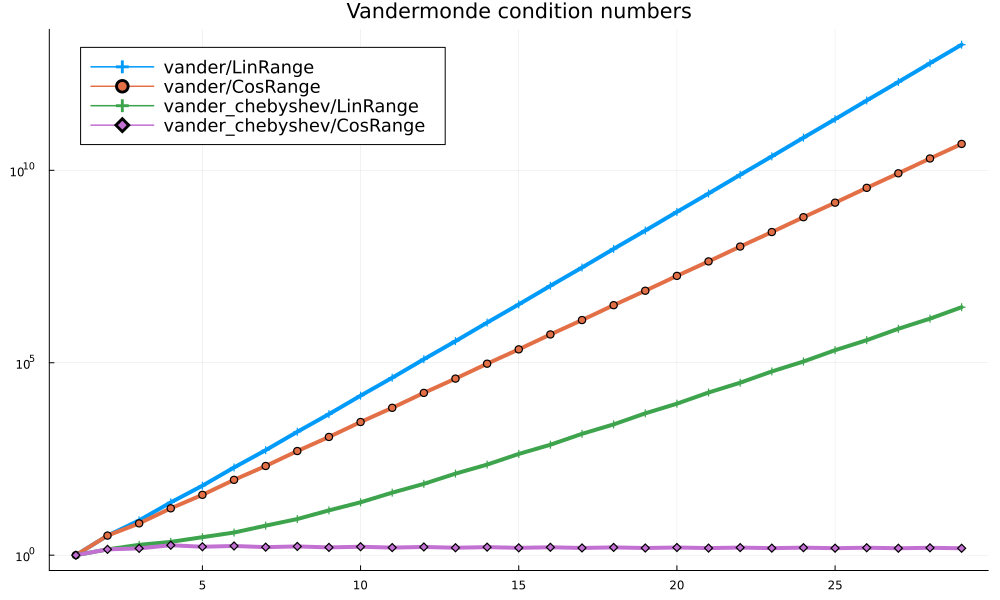

In [4]:
plot_vcond(mat, points) = plot!([
        cond(mat(points(-1, 1, n)))
        for n in 2:30], label="$mat/$points", marker=:auto, yscale=:log10)

plot(title="Vandermonde condition numbers", legend=:topleft, size=(1000, 600))
plot_vcond(vander, LinRange)
plot_vcond(vander, CosRange)
plot_vcond(vander_chebyshev, LinRange)
plot_vcond(vander_chebyshev, CosRange)

# Lagrange interpolating polynomials revisited

Let's re-examine the Lagrange polynomials as we vary the points.

cond(A) = 3.388221057514252


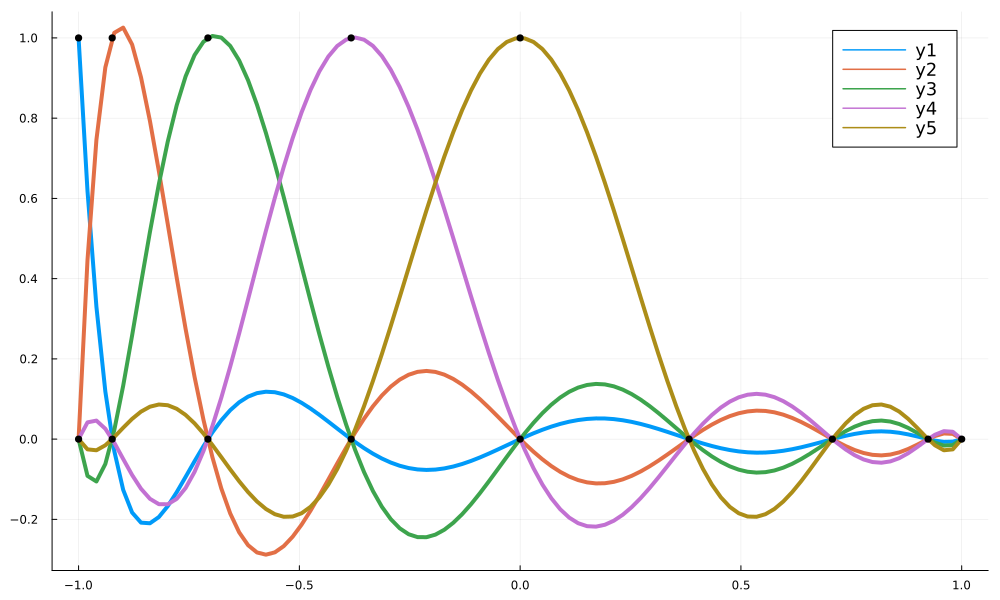

In [5]:
x = CosRange(-1, 1, 9) # CosRange?
s = LinRange(-1, 1, 100)
A = vander_chebyshev(s, length(x)) /
    vander_chebyshev(x)
@show cond(A)
plot(s, A[:,1:5], size=(1000, 600))
scatter!(x[1:5], ones(5), color=:black, label=nothing)
scatter!(x, zero(x), color=:black, label=nothing)

* Are there artifacts?

# Piecewise interpolation

In [6]:
function interp_nearest(x, s)
    A = zeros(length(s), length(x))
    for (i, t) in enumerate(s)
        loc = nothing
        dist = Inf
        for (j, u) in enumerate(x)
            if abs(t - u) < dist
                loc = j
                dist = abs(t - u)
            end
        end
        A[i, loc] = 1
    end
    A
end
interp_nearest(LinRange(-1, 1, 3), LinRange(0, 1, 4))

4×3 Matrix{Float64}:
 0.0  1.0  0.0
 0.0  1.0  0.0
 0.0  0.0  1.0
 0.0  0.0  1.0

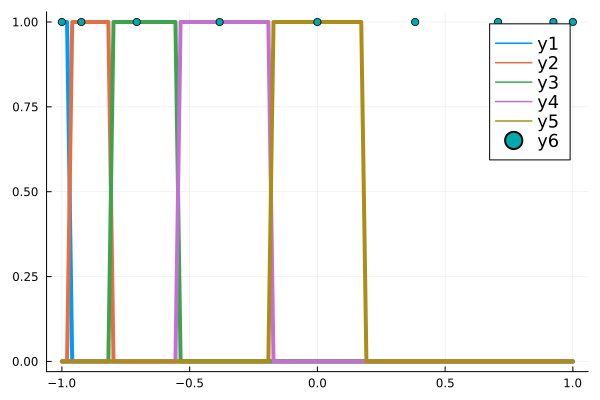

In [7]:
A = interp_nearest(x, s)
plot(s, A[:, 1:5])
scatter!(x, ones(length(x)))

## I don't see any visual artifacts


In [8]:
x = LinRange(-1, 1, 30)
A = interp_nearest(x, s)
cond(A)

1.414213562373095

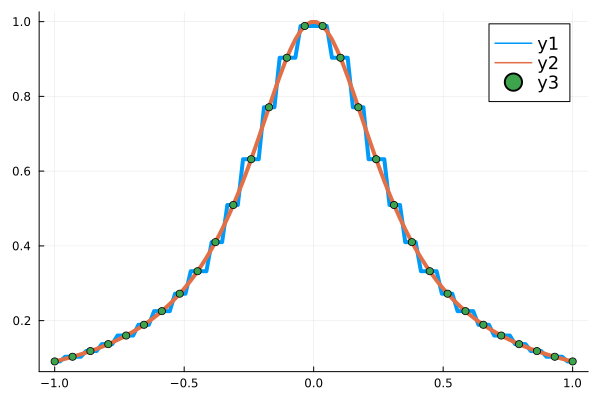

In [9]:
plot(s, A * runge.(x))
plot!(s, runge.(s))
scatter!(x, runge.(x))

In [29]:
function interp_chebyshev(x, xx)
    vander_chebyshev(xx, length(x)) / vander_chebyshev(x)
end

function interp_monomial(x, xx)
    vander(xx, length(x)) * inv(vander(x))
end

function interp_error(ieval, x, xx, test)
    """Compute norm of interpolation error for function test
    using method interp_and_eval from points x to points xx.
    """
    A = ieval(x, xx)
    y = test.(x)
    yy = test.(xx)
    norm(A * y - yy, Inf)
end

function plot_convergence(ievals, ptspaces; xscale=:log10, yscale=:log10, maxpts=40)
    """Plot convergence rates for an interpolation scheme applied
    to a set of tests.
    """
    xx = LinRange(-1, 1, 100)
    ns = 2:maxpts
    fig = plot(title="Convergence",
        xlabel="Number of points",
        ylabel="Interpolation error",
        xscale=xscale,
        yscale=yscale,
        legend=:bottomleft,
        size=(1000, 800))
    for ieval in ievals
        for ptspace in ptspaces
            for test in [runge]
                errors = [interp_error(ieval, ptspace(-1, 1, n), xx, test)
                         for n in ns]
                plot!(ns, errors, marker=:circle, label="$ieval/$ptspace")
            end
        end
    end
    for k in [1, 2, 3]
        plot!(ns, ns .^ (-1.0*k), color=:black, label="\$n^{-$k}\$")
    end
    fig
end


plot_convergence (generic function with 1 method)

# So maybe it's not that accurate?


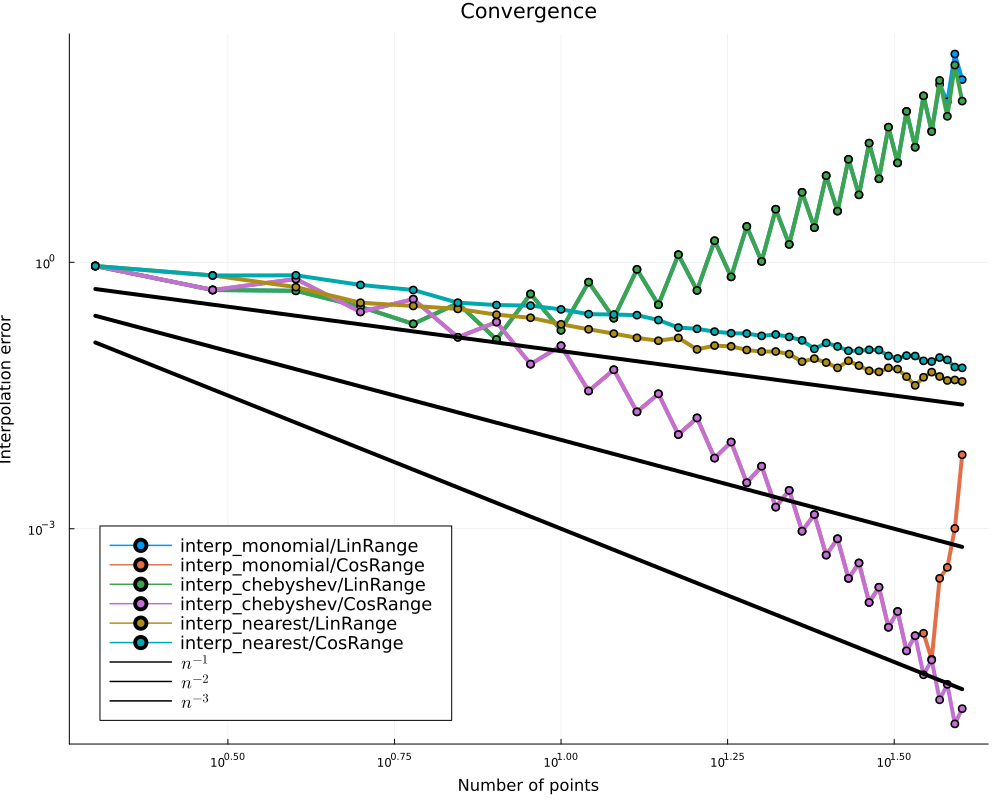

In [30]:
plot_convergence([interp_monomial, interp_chebyshev, interp_nearest], [LinRange, CosRange])

# Observations

* Piecewise constant interpolation is **well conditioned** on any set of points
* Piecewise constant interpolation **converges very slowly** (needs many points to increase accuracy)
* Chebyshev/polynomial interpolation **requires special input points**, otherwise it is **ill conditioned**
* Chebyshev/polynomial interpolation has **"exponential" convergence** for smooth enough functions


# How could we improve the accuracy?



# Cubic splines

* Piecewise cubic function
* Continuous values
* Continuous derivatives

# Splines

If we are given an arbitrary distribution of points, interpolation with a single polynomial is not robust.  Piecewise constant interpolation is not very accurate and gives a rough function.
We could improve the accuracy by using a piecewise linear function, but the accuracy is still limited and the function still isn't smooth (there is a "corner" where the slope changes at each data point).
Splines are a way to guarantee an arbitrary amount of smoothness.
The idea is that given sorted input points $\{x_i\}_{i=0}^n$, we compute an interpolating polynomial $s_i(x)$ on every interval $(x_i, x_{i+1})$.

## Interpolation
Given a function value $y_i$ at each $x_i$, we require
$$\begin{split}
  s_i(x_i) &= y_i \\
  s_i(x_{i+1}) &= y_{i+1}
  \end{split} $$
so that the polynomial interpolates our data.
If the polynomial has order greater than 1, we are left with some extra degrees of freedom.
To provide a unique solution, we'll need to add conditions.

## Smoothness

The conditions above guarantee continuity, but not smoothness.  We use our extra degree(s) of freedom to impose smoothness conditions of the form
$$\begin{split}
  s_i'(x_{i+1}) &= s_{i+1}'(x_{i+1}) \\
  s_i''(x_{i+1}) &= s_{i+1}''(x_{i+1}) .
\end{split}$$
These conditions, which are applied at the interior nodes ($x=1,\dotsc,n-1$) couple the splines from adjacent intervals and causes the spline approximation to be globally coupled.

## End-point conditions

The conditions above are still not enough to guarantee a unique spline.
Suppose we use quadratic polynomials for each $s_i$.  Then with $n$ intervals, we have $n$ degrees of freedom after imposing the interpolation condition.  Meanwhile, there are only $n-1$ internal nodes.  If we impose continuity of the first derivative, we have $n - (n-1) = 1$ undetermined degrees of freedom.  We could fix this by imposing a boundary condition, such as that the slope at one end-point (e.g., $s_0'(x_0)$) was equal to a known value.  This is not symmetric and is often an unnatural condition.

Suppose we use cubic polynomials.  Now we have two degrees of freedom per interval after imposing the interpolation condition.  If we impose continuity of the first and second derivatives, we have $2n - 2(n-1) = 2$ remaining degrees of freedom.  A common choice here is the "natural spline", $s_0''(x_0) = 0$ and $s_n''(x_n) = 0$.  Cubic splines are the most popular spline in this family.

## Solving spline interpolation problems

We need to choose a basis for the polynomials $s_i(x)$.  We could choose
$$ s_i(x) = a_i + b_i x + c_i x^2 + d_i x^3 $$
but this would be very ill-conditioned when the interval $(x_i,x_{i+1})$ is far from zero.
A better-conditioned choice is
$$ s_i(x) = a_i + b_i(x - x_i) + c_i(x - x_i)^2 + d_i(x - x_i)^3 . $$
The interpolation property gives
$$\begin{split}
a_i &= y_i \\
a_i + b_i(x_{i+1} - x_i) + c_i(x_{i+1} - x_i)^2 + d_i(x_{i+1} - x_i)^3 &= y_{i+1}
\end{split}$$
and continuity of the first and second derivatives gives
$$\begin{split}
  s_i'(x_{i+1}) = b_i + 2c_i(x_{i+1} - x_i) + 3d_i(x_{i+1}-x_i)^2 &= b_{i+1} = s_{i+1}'(x_{i+1}) \\
  2c_i + 6d_i(x_{i+1} - x_i) &= 2 c_{i+1} .
\end{split}$$
After trivially eliminating the $a_i$, this is a block bidiagonal system ($3\times 3$ blocks).  We can reduce this to a scalar tridiagonal system.  Define $\delta_i = x_{i+1} - x_i$ and $\Delta_i = y_{i+1} - y_i$.  Then eliminate $d_i$ using
$$ d_i = \frac{c_{i+1} - c_i}{3\delta_i} $$
and $b_i$ using
$$\begin{split}
  b_i\delta i &= \Delta_i - c_i\delta_i^2 - \underbrace{\frac{c_{i+1} - c_i}{3\delta_i}}_{d_i} \delta_i^3 \\
  b_i &= \frac{\Delta_i}{\delta_i} - \frac{\delta_i}{3}(c_{i+1} + 2c_i) .
\end{split}$$
Substituting into the equation for continuity of the first derivative gives
$$ \frac{\Delta_i}{\delta i} - \frac{\delta_i}{3}(c_{i+1} + 2c_i) + 2c_i\delta_i + (c_{i+1} - c_i)\delta_i = 
\frac{\Delta_{i+1}}{\delta_{i+1}} - \frac{\delta_{i+1}}{3}(c_{i+2} + 2c_{i+1}) $$
which reduces to
$$ \delta_i c_i + 2(\delta_i + \delta_{i+1}) c_{i+1} + \delta_{i+1} c_{i+2} = 3\left(\frac{\Delta_{i+1}}{\delta_{i+1}} - \frac{\Delta_i}{\delta_i}\right) . $$
To impose boundary conditions, we add a dummy interval on the right end (the actual value of $x_{n+1}>x_n$ cancels out) so that the equation above is valid for $i = 0,\dotsc,n-2$ and the right boundary condition $s_{n-1}''(x_n) = s_n''(x_n)$ becomes $c_n = 0$. The left boundary condition $s_0''(x_0) = 0$ yields $c_0 = 0$, so we must solve
\begin{equation}
\begin{bmatrix}
1 & & & & & & \\
\delta_0 & 2(\delta_0+\delta_1) & \delta_1 & & & & \\
& \delta_1 & 2(\delta_1+\delta_2) & \delta_2 & & & \\
& & \ddots & \ddots & \ddots & & \\
& & & & \delta_{n-2} & 2(\delta_{n-2}+\delta_{n-1}) & \delta_{n-1} \\
& & & & & & 1 \\
\end{bmatrix}
\begin{bmatrix} c_0 \\ c_1 \\ \vdots \\ \\ c_{n-1} \\ c_n \end{bmatrix} = 
\begin{bmatrix} 0 \\ 3\left(\frac{\Delta_1}{\delta_1} - \frac{\Delta_0}{\delta_0} \right) \\ \vdots \\ 3\left(\frac{\Delta_{n-1}}{\delta_{n-1}} - \frac{\Delta_{n-2}}{\delta_{n-2}}\right) \\ 0 \end{bmatrix} .
\end{equation}
After solving this equation for $c_i$, we will recover $b_i$ and $d_i$, and then can evaluate the spline at arbitrary points.

In [57]:
function spline_interp_and_eval(x, s)
    n = length(x) - 1
    function s_interp(y)
        delta = x[2:end] - x[1:end-1] # diff(x)
        Delta = diff(y)
        T = zeros(n+1, n+1)
        T[1,1] = 1
        for i in 2:n
            T[i, i-1:i+1] = [delta[i-1], 2*(delta[i-1] + delta[i]), delta[i]]
        end
        T[end,end] = 1
        rhs = zeros(n+1)
        rhs[2:end-1] = 3*(Delta[2:end] ./ delta[2:end] - Delta[1:end-1] ./ delta[1:end-1])
        c = T \ rhs
        S = zeros(n, 5)
        S[:, 1] = x[1:end-1]
        S[:, 3] = c[1:end-1]
        S[:, 5] = y[1:end-1]
        S[:, 2] = diff(c) ./ (3 * delta)
        S[:, 4] = Delta ./ delta - delta/3 .* (2*c[1:end-1] + c[2:end])
        S
    end
    
    function polyval(p, x)
        f = p[1]
        for c in p[2:end]
            f = f * x + c
        end
        f
    end

    function s_eval(S, s)
        f = zero(s)
        for (i, t) in enumerate(s)
            left = max(1, searchsortedfirst(S[:,1], t) - 1)
            f[i] = polyval(S[left, 2:end], t - S[left, 1])
        end
        f
    end
    
    A = zeros(length(s), length(x))
    aye = diagm(ones(length(x)))
    for i in 1:length(x)
        e = aye[:, i]
        S = s_interp(e)
        A[:, i] = s_eval(S, s)
    end
    A
end

# Cubic spline interpolation

spline_interp_and_eval (generic function with 1 method)

# How well do splines work?

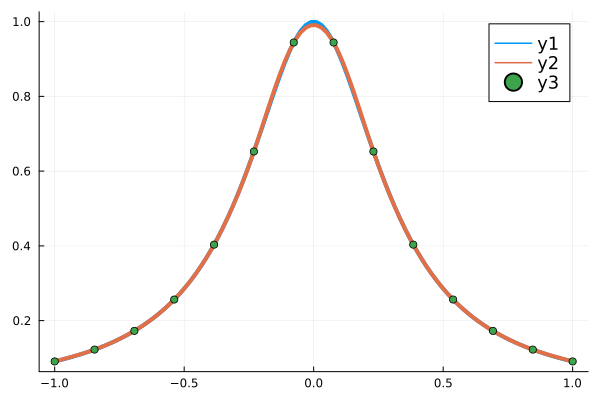

In [61]:
x = LinRange(-1, 1, 14)
y = runge.(x)
s = LinRange(-1, 1, 100)
A = spline_interp_and_eval(x, s)
plot(s, [runge.(s) A * y])
scatter!(x, y)

cond(A) = 1.8495159246421367


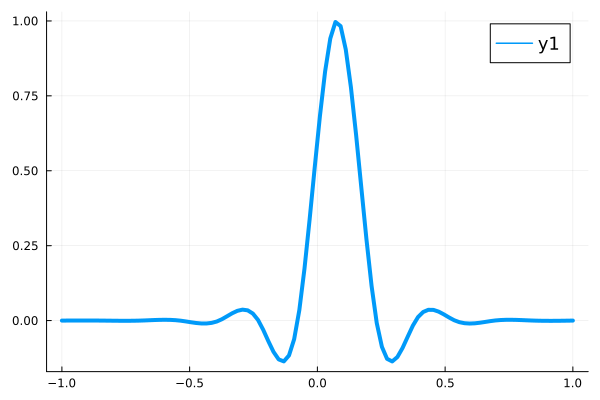

In [63]:
@show cond(A)
plot(s, A[:,8])

# Interpolations.jl

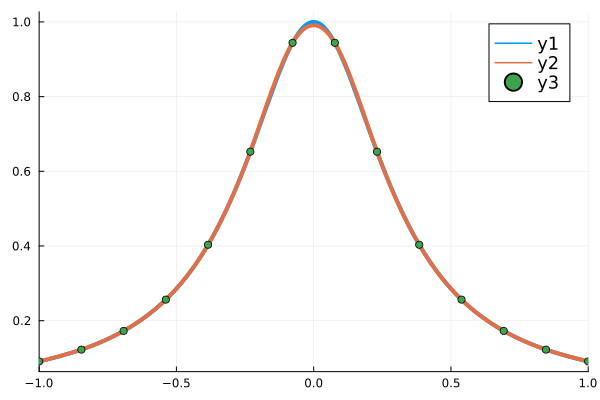

In [75]:
using Interpolations

x = LinRange(-1, 1, 14)
y = runge.(x)
flin = LinearInterpolation(x, y)
fspline = CubicSplineInterpolation(x, y)
plot([runge, t -> fspline(t)], xlims=(-1, 1))
scatter!(x, y)

In [77]:
xx = LinRange(-1, 1, 100)
norm(runge.(xx) - fspline.(xx))

0.022048279334709518

cond(A) = 1.8495159246421367


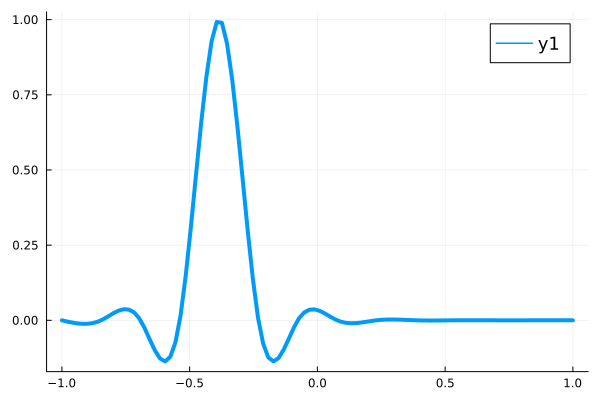

In [79]:
# Make a matrix so we can compute condition number
s = LinRange(-1, 1, 100)
A = zeros(100, length(x))
for i in 1:length(x)
    y = zero.(x)
    y[i] = 1
    f = CubicSplineInterpolation(x, y)
    A[:, i] = f.(s)
end
@show cond(A)
plot(s, A[:, 5])